# Oil Spill Detection - Advanced Data Preprocessing
## AI-Driven System for Oil Spill Identification and Monitoring

This notebook contains comprehensive preprocessing for SAR and RGB satellite imagery oil spill detection.

## 1. Import Required Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from scipy import ndimage
from skimage import filters, exposure
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Dataset Configuration

In [2]:
# Dataset paths
DATASET_PATH = "DataSet"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "val")
TEST_PATH = os.path.join(DATASET_PATH, "test")

# Image configuration
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
IMAGE_TYPE = 'RGB'  # Change to 'SAR' for SAR images

print(f"Dataset path: {DATASET_PATH}")
print(f"Image type: {IMAGE_TYPE}")
print(f"Image size: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")

Dataset path: DataSet
Image type: RGB
Image size: 256x256x3


## 3. Dataset Exploration

In [3]:
def count_files(path):
    """Count number of files in images and masks folders"""
    images_path = os.path.join(path, "images")
    masks_path = os.path.join(path, "masks")
    
    if os.path.exists(images_path) and os.path.exists(masks_path):
        img_count = len([f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        mask_count = len([f for f in os.listdir(masks_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        return img_count, mask_count
    return 0, 0

# Count files in each split
train_imgs, train_masks = count_files(TRAIN_PATH)
val_imgs, val_masks = count_files(VAL_PATH)
test_imgs, test_masks = count_files(TEST_PATH)

print("Dataset Statistics:")
print(f"Train: {train_imgs} images, {train_masks} masks")
print(f"Validation: {val_imgs} images, {val_masks} masks")
print(f"Test: {test_imgs} images, {test_masks} masks")
print(f"Total: {train_imgs + val_imgs + test_imgs} images")

Dataset Statistics:
Train: 0 images, 0 masks
Validation: 0 images, 0 masks
Test: 0 images, 0 masks
Total: 0 images


## 4. SAR-Specific Preprocessing Functions

In [4]:
def preprocess_sar(image, method='lee'):
    """Preprocess SAR image: speckle noise reduction + normalization"""
    # 1. Speckle noise reduction
    if method == 'lee':
        kernel = np.ones((5,5))/25
        mean = cv2.filter2D(image, -1, kernel)
        var = cv2.filter2D(image**2, -1, kernel) - mean**2
        k = var / np.maximum(var + mean**2, 1e-10)
        image = mean + k*(image - mean)
    
    # 2. Log scaling + z-score normalization
    image = np.log(image + 1e-10)
    image = (image - image.mean()) / (image.std() + 1e-10)
    
    # 3. Scale to [0,1]
    image = (image - image.min()) / (image.max() - image.min() + 1e-10)
    
    return image.astype(np.float32)

def preprocess_rgb(image):
    """Normalize RGB image to [0,1]"""
    return image.astype(np.float32)/255.0

print("Preprocessing functions ready!")

Preprocessing functions ready!


## 5. Image Preprocessing Functions

In [5]:
def load_image(image_path, image_type='RGB'):
    """Load and preprocess image"""
    if image_type == 'SAR':
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = preprocess_sar(img.astype(np.float32)/255.0)
        img = np.stack([img, img, img], axis=-1)
    else:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = preprocess_rgb(img)
    return img

def load_mask(mask_path):
    """Load and preprocess mask"""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    mask = (mask > 127).astype(np.float32)
    return mask

print("Image preprocessing functions ready!")

Image preprocessing functions ready!


## 6. Data Augmentation Functions

In [6]:
def geometric_augmentation(image, mask):
    """Apply geometric augmentations"""
    # Random horizontal flip
    if np.random.random() > 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    
    # Random vertical flip
    if np.random.random() > 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)
    
    # Random rotation (90, 180, 270 degrees)
    k = np.random.randint(0, 4)
    image = np.rot90(image, k)
    mask = np.rot90(mask, k)
    
    return image, mask

def photometric_augmentation(image, image_type='RGB'):
    """Apply photometric augmentations"""
    if image_type == 'RGB':
        # Brightness variation
        if np.random.random() > 0.5:
            brightness = np.random.uniform(0.8, 1.2)
            image = np.clip(image * brightness, 0, 1)
        
        # Contrast variation
        if np.random.random() > 0.5:
            contrast = np.random.uniform(0.8, 1.2)
            image = np.clip((image - 0.5) * contrast + 0.5, 0, 1)
        
        # Random noise injection
        if np.random.random() > 0.7:
            noise = np.random.normal(0, 0.02, image.shape)
            image = np.clip(image + noise, 0, 1)
    
    elif image_type == 'SAR':
        # SAR-specific augmentations
        if np.random.random() > 0.5:
            speckle = np.random.gamma(1, 0.1, image.shape)
            image = np.clip(image * speckle, 0, 1)
        
        if np.random.random() > 0.5:
            scale = np.random.uniform(0.9, 1.1)
            image = np.clip(image * scale, 0, 1)
    
    return image

print("Data augmentation functions ready!")

Data augmentation functions ready!


## 7. Data Loading Functions

In [7]:
def load_dataset(dataset_path, split, apply_augmentation=False):
    """Load complete dataset for a given split"""
    images_path = os.path.join(dataset_path, split, "images")
    masks_path = os.path.join(dataset_path, split, "masks")
    
    image_files = sorted([f for f in os.listdir(images_path) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    mask_files = sorted([f for f in os.listdir(masks_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    print(f"Loading {len(image_files)} samples from {split} set...")
    
    images, masks = [], []
    
    for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
        img_path = os.path.join(images_path, img_file)
        mask_path = os.path.join(masks_path, mask_file)
        
        if not os.path.exists(img_path) or not os.path.exists(mask_path):
            continue
        
        image = load_image(img_path, IMAGE_TYPE)
        mask = load_mask(mask_path)
        
        if apply_augmentation:
            image, mask = geometric_augmentation(image, mask)
            image = photometric_augmentation(image, IMAGE_TYPE)
        
        images.append(image)
        masks.append(mask)
        
        if (i + 1) % 50 == 0:
            print(f"Processed {i + 1}/{len(image_files)} samples")
    
    return np.array(images), np.array(masks)

print("Data loading functions ready!")

Data loading functions ready!


## 8. Load and Preprocess All Data

In [8]:
# Load training data with augmentation
print("Loading training data...")
X_train, y_train = load_dataset(DATASET_PATH, "train", apply_augmentation=True)

# Load validation data
print("\nLoading validation data...")
X_val, y_val = load_dataset(DATASET_PATH, "val", apply_augmentation=False)

# Load test data
print("\nLoading test data...")
X_test, y_test = load_dataset(DATASET_PATH, "test", apply_augmentation=False)

print("\nData loading completed!")
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Loading training data...


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'DataSet\\train\\images'

## 9. Data Quality Checks

In [34]:
def check_data_quality(images, masks, dataset_name):
    """Perform quality checks on the dataset"""
    print(f"\n=== {dataset_name} Data Quality Check ===")
    print(f"Images shape: {images.shape}")
    print(f"Masks shape: {masks.shape}")
    print(f"Images range: [{images.min():.3f}, {images.max():.3f}]")
    print(f"Masks range: [{masks.min():.3f}, {masks.max():.3f}]")
    
    oil_percentage = (np.sum(masks == 1) / masks.size) * 100
    print(f"Oil spill pixels: {oil_percentage:.2f}% of total pixels")

check_data_quality(X_train, y_train, "Training")
check_data_quality(X_val, y_val, "Validation")
check_data_quality(X_test, y_test, "Test")


=== Training Data Quality Check ===
Images shape: (811, 256, 256, 3)
Masks shape: (811, 256, 256)
Images range: [0.000, 1.000]
Masks range: [0.000, 1.000]
Oil spill pixels: 63.17% of total pixels

=== Validation Data Quality Check ===
Images shape: (203, 256, 256, 3)
Masks shape: (203, 256, 256)
Images range: [0.000, 1.000]
Masks range: [0.000, 1.000]
Oil spill pixels: 60.24% of total pixels

=== Test Data Quality Check ===
Images shape: (254, 256, 256, 3)
Masks shape: (254, 256, 256)
Images range: [0.000, 1.000]
Masks range: [0.000, 1.000]
Oil spill pixels: 62.90% of total pixels


## 10. Visualize Preprocessed Data

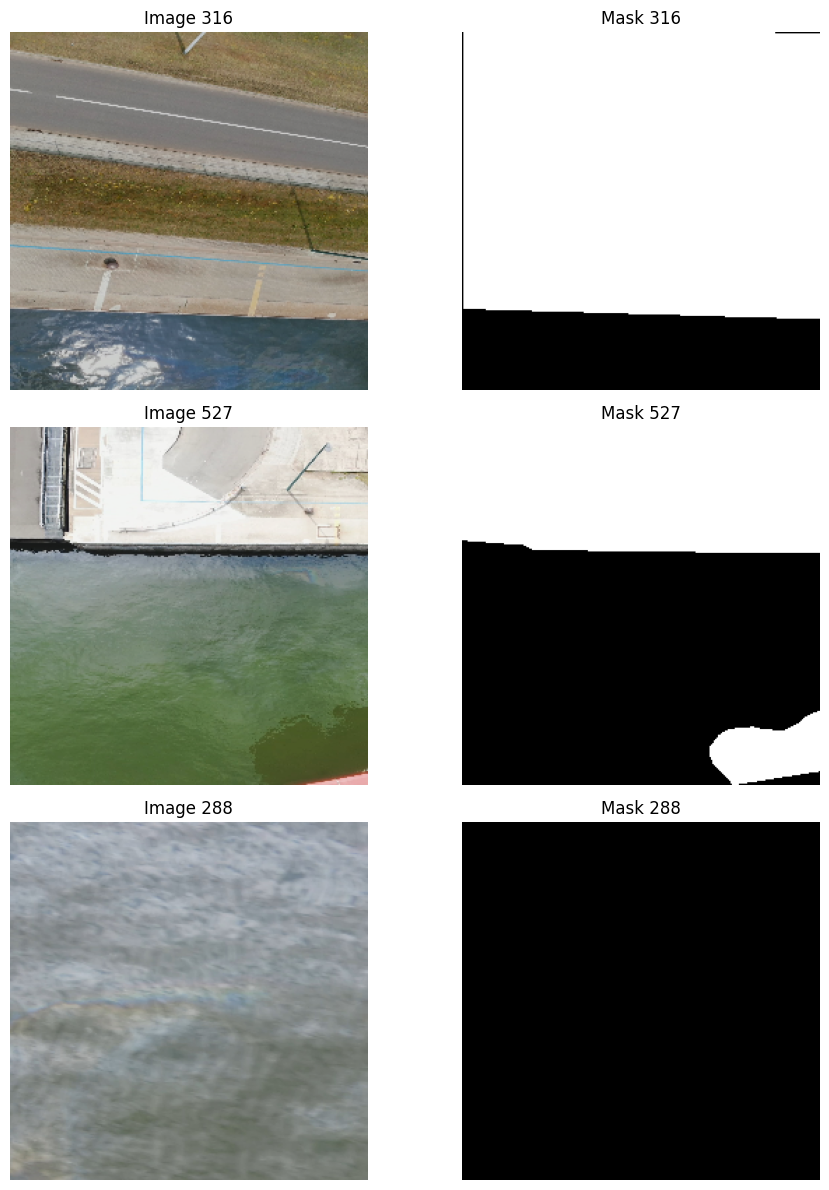

In [35]:
def visualize_samples(images, masks, num_samples=3):
    """Visualize preprocessed samples"""
    indices = np.random.choice(len(images), min(num_samples, len(images)), replace=False)
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(indices):
        axes[i, 0].imshow(images[idx])
        axes[i, 0].set_title(f'Image {idx}')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(masks[idx], cmap='gray')
        axes[i, 1].set_title(f'Mask {idx}')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples(X_train, y_train, 3)

## 11. Data Summary

In [36]:
print("\n" + "="*50)
print("PREPROCESSING SUMMARY")
print("="*50)
print(f"✓ Dataset: {DATASET_PATH}")
print(f"✓ Image type: {IMAGE_TYPE}")
print(f"✓ Image size: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")
print(f"✓ Training samples: {len(X_train)}")
print(f"✓ Validation samples: {len(X_val)}")
print(f"✓ Test samples: {len(X_test)}")
print("\nFeatures:")
print("✓ SAR speckle noise reduction (Lee filter)")
print("✓ SAR log-scaling + z-score normalization")
print("✓ RGB normalization to [0,1]")
print("✓ Binary masks (oil=1, background=0)")
print("✓ Geometric augmentation (flips, rotations)")
print("✓ Photometric augmentation (brightness, contrast, noise)")
print("✓ SAR-specific augmentation (speckle simulation)")
print("\nData ready for model training!")
print("="*50)


PREPROCESSING SUMMARY
✓ Dataset: DataSet
✓ Image type: RGB
✓ Image size: 256x256x3
✓ Training samples: 811
✓ Validation samples: 203
✓ Test samples: 254

Features:
✓ SAR speckle noise reduction (Lee filter)
✓ SAR log-scaling + z-score normalization
✓ RGB normalization to [0,1]
✓ Binary masks (oil=1, background=0)
✓ Geometric augmentation (flips, rotations)
✓ Photometric augmentation (brightness, contrast, noise)
✓ SAR-specific augmentation (speckle simulation)

Data ready for model training!
